# EDA

In this section, the datset is imported, cleaned, formatted, explored and feature engineering are performed

## Simple exploration and cleaning

### Import and explore

In [13]:
import pandas as pd
df = pd.read_csv("../data/energy data/london_energy.csv")
len(df)

3510433

In [14]:
# dataset link: https://www.kaggle.com/datasets/emmanuelfwerr/london-homes-energy-data

In [15]:
df.head()

,LCLid,Date,KWH
0,MAC000002,2012-10-12,7.098
1,MAC000002,2012-10-13,11.087
2,MAC000002,2012-10-14,13.223
3,MAC000002,2012-10-15,10.257
4,MAC000002,2012-10-16,9.769


In [16]:
# Converting the date column to correct format
df["Date"] = pd.to_datetime(df["Date"], format = "%Y-%m-%d" )

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3510433 entries, 0 to 3510432
Data columns (total 3 columns):
 #   Column  Dtype         
---  ------  -----         
 0   LCLid   object        
 1   Date    datetime64[ns]
 2   KWH     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 80.3+ MB


In [18]:
# Check the observations per house
import numpy as np
unique_house_id = np.unique(df["LCLid"])

In [19]:
house_counts = df["LCLid"].value_counts()
print(house_counts,len(house_counts))

LCLid
MAC000153    829
MAC000150    829
MAC000155    829
MAC000148    829
MAC000156    829
            ... 
MAC005563      1
MAC001150      1
MAC005559      1
MAC005556      1
MAC005560      1
Name: count, Length: 5566, dtype: int64 5566


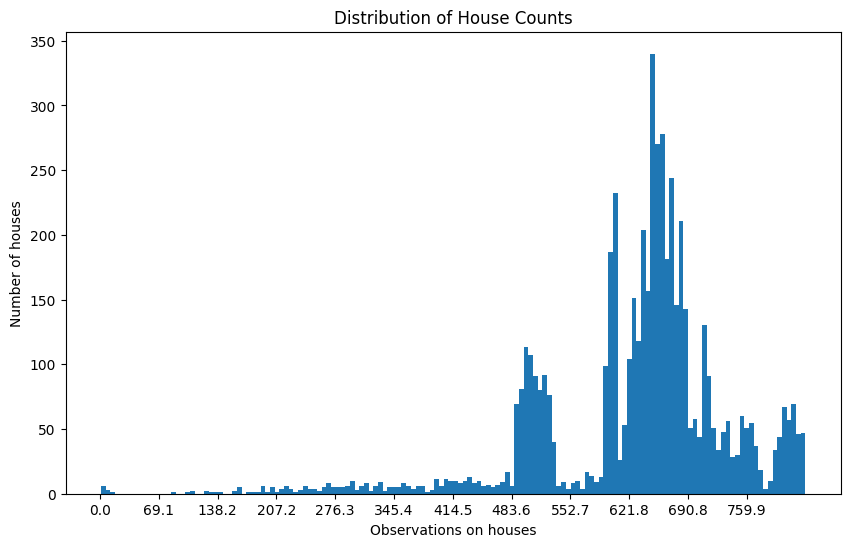

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Visualizing the observations of data by houses
max_obs = house_counts.max()
steps = max_obs/12
figure = plt.figure(figsize=(10,6))
plt.hist(house_counts, bins=150)
plt.xlabel('Observations on houses')
plt.ylabel('Number of houses')
plt.title('Distribution of House Counts')
plt.xticks(np.arange(0, max_obs, steps ))
plt.show();

In [21]:
# Houses with fewer observations than threshold
thres = 490
under_threshold = len(house_counts[house_counts < thres])
print(f"Total house count: {len(house_counts)}")
print(f"Maximum observations: {max_obs}")
print(f"Houses under threshold: {under_threshold}")

Total house count: 5566
Maximum observations: 829
Houses under threshold: 366


In [22]:
# Check the mean and median consumption of raw data
np.mean(df['KWH']), np.median(df['KWH'])

(np.float64(10.13000637556677), np.float64(7.819))

In [23]:
# The mean and median has high difference, which is suspiciois,
# To investigate this Distribution of energy consumption is visuzlized

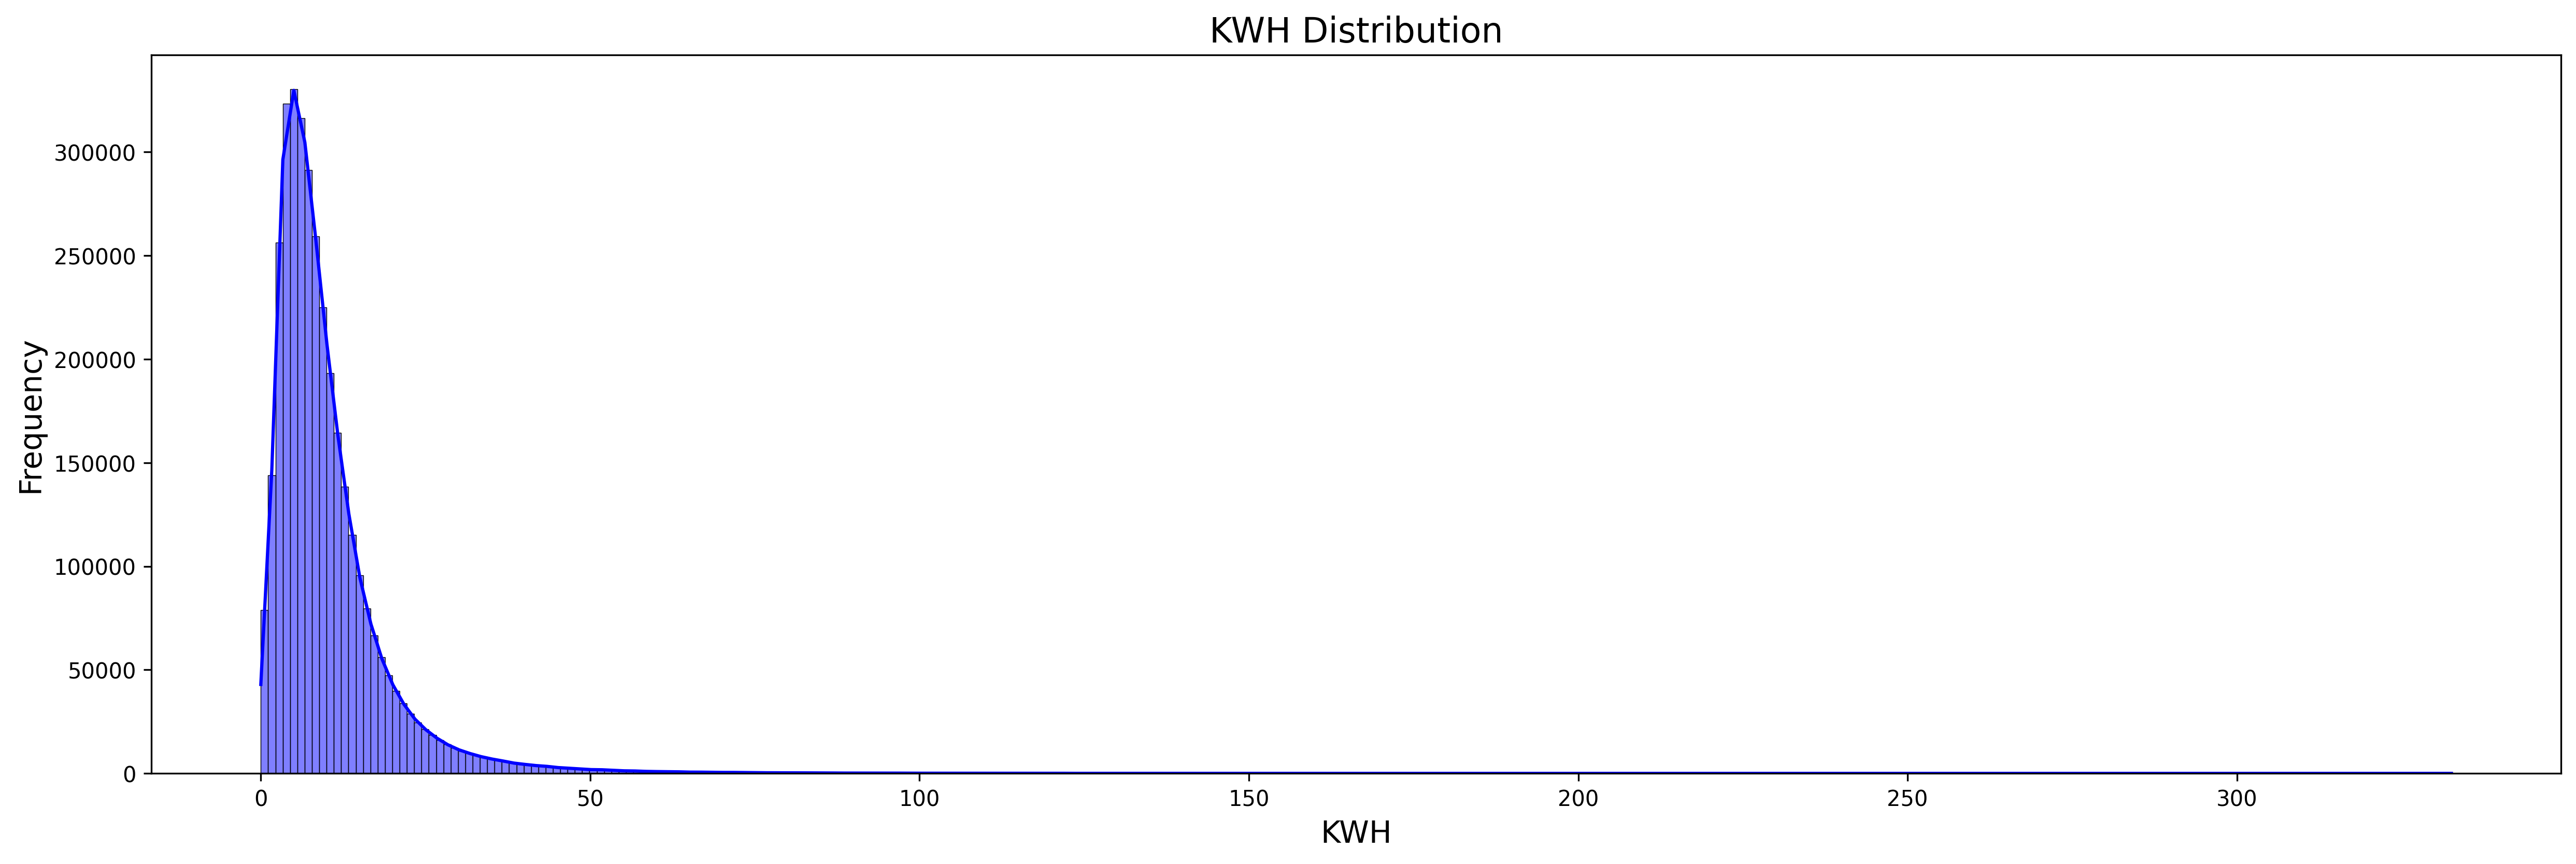

Skewness of KWH: 3.849846804970323
Kurtosis of KWH: 33.43966871860251


In [24]:
from scipy.stats import skew, kurtosis
import seaborn as sns
# Plot the distribution of KWH
plt.figure(figsize=(20, 6), dpi = 300)
sns.histplot(df['KWH'], kde=True, color='blue', bins=300)
plt.title('KWH Distribution', fontsize=16)
plt.xlabel('KWH', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

# Calculate skewness and kurtosis for KWH
kwh_skewness = skew(df['KWH'])
kwh_kurtosis = kurtosis(df['KWH'])

print(f"Skewness of KWH: {kwh_skewness}")
print(f"Kurtosis of KWH: {kwh_kurtosis}")

In [25]:
# This is unsusally abnormal. There are some ouliers which have extremly large values of KWH
# Thus, to further investigate this, only the high energy consuming houses are taken

In [26]:
# Check the high energy consumption and it's proportion
len_high = len(df[df['KWH']>25])
print(len_high, round((len_high/len(df))*100,2))

189930 5.41


In [27]:
# Extract the high energy data
high_df = df[df['KWH']>25].reset_index(drop=True)
high_df.head()

,LCLid,Date,KWH
0,MAC000002,2013-02-28,32.628
1,MAC000002,2013-03-01,39.284
2,MAC000002,2013-03-02,26.292
3,MAC000002,2013-03-04,25.447
4,MAC000002,2013-03-05,32.856


In [28]:
max(high_df['Date']), min(high_df['Date'])

(Timestamp('2014-02-27 00:00:00'), Timestamp('2011-11-24 00:00:00'))

In [29]:
# Check how many houses are there that consumed very high energy
len(set(high_df["LCLid"]))

2258

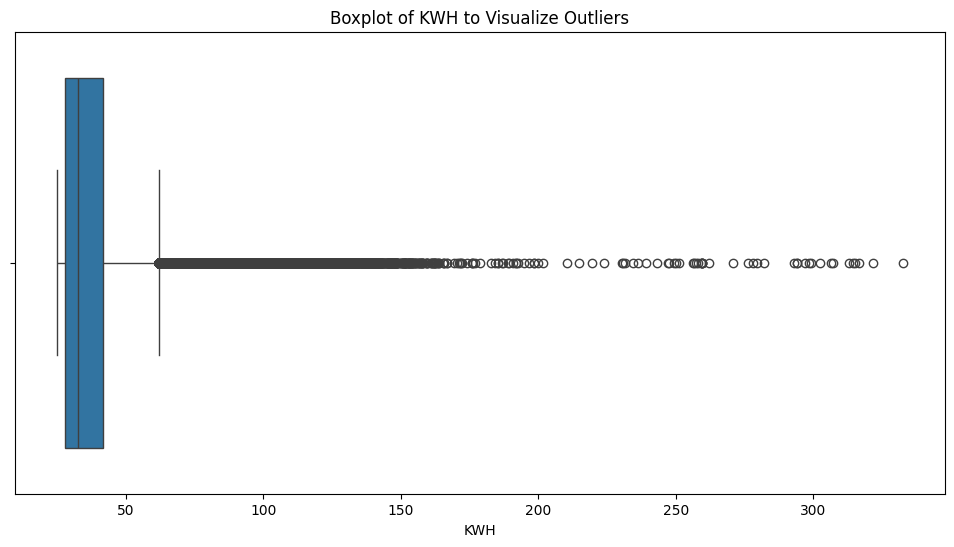

In [30]:
# Check the outliers with box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='KWH', data=high_df)
plt.title('Boxplot of KWH to Visualize Outliers')
plt.show()

In [31]:
# To visualize the high energy consumption, the aggregate by date is taken
high_df_avg = high_df.groupby('Date')['KWH'].mean()
high_df_avg.head()

Date
2011-11-24    29.7220
2011-11-25    30.0710
2011-11-26    30.9275
2011-11-27    32.2510
2011-11-28    40.7100
Name: KWH, dtype: float64

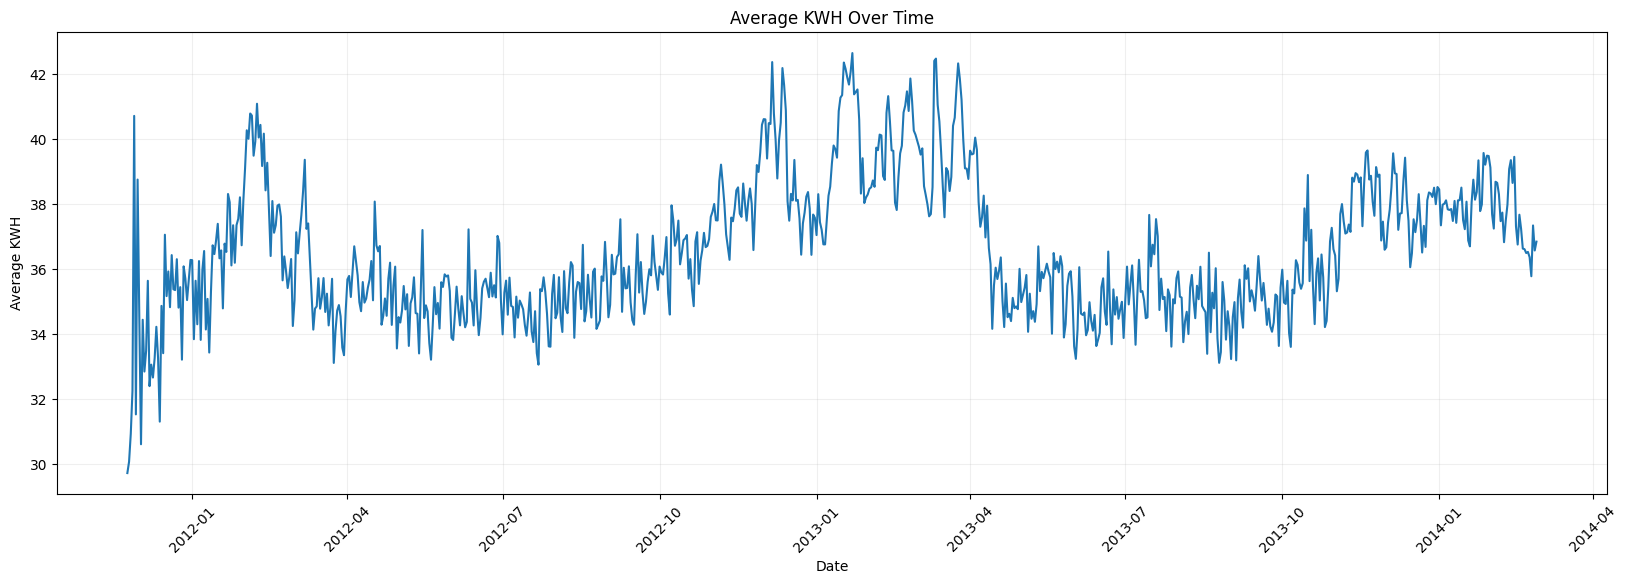

In [32]:
# Visualize the high energy consumption over time
plt.figure(figsize=(20, 6))
plt.plot(high_df_avg.index, high_df_avg.values)
plt.xlabel('Date')
plt.ylabel('Average KWH')
plt.title('Average KWH Over Time')
plt.grid(alpha = 0.2)
plt.xticks(rotation=45)
plt.show();

In [33]:
# This shows that there are certain houses in the data which generally  consume more energy than rest of the houses in overall.
# Thus, even though the the outliers are extremly high, They will be taken into consideration as they will get normalized while processing the data
# when aggregating and won't affect the model

### Cleaning
Remove the houses with few observations

In [34]:
filtered_df = df[df["LCLid"].isin(house_counts[house_counts >= thres].index)]
filtered_df.head(), len(filtered_df)

(       LCLid       Date     KWH
 0  MAC000002 2012-10-12   7.098
 1  MAC000002 2012-10-13  11.087
 2  MAC000002 2012-10-14  13.223
 3  MAC000002 2012-10-15  10.257
 4  MAC000002 2012-10-16   9.769,
 3384445)

In [35]:
# Check for the data loss
len(df)-len(filtered_df), (len(df)-len(filtered_df))/len(df)*100

(125988, 3.5889589688793375)

### Get the overall consumption of houses by date

In [36]:
# Grouping by date and calculating mean, median, and standard deviation for 'KWH'
stats_kwh = filtered_df.groupby('Date')['KWH'].agg(['mean', 'median', 'std'])

# Convert the results into a DataFrame
stats_kwh = pd.DataFrame({
    'date': stats_kwh.index.tolist(),
    'mean_consumption': stats_kwh['mean'].values.tolist(),
    'median_consumption': stats_kwh['median'].values.tolist(),
    'std_consumption': stats_kwh['std'].values.tolist()
})

# Convert the 'date' column to datetime
stats_kwh['date'] = pd.to_datetime(stats_kwh['date'])

# Display the results
stats_kwh.head()


,date,mean_consumption,median_consumption,std_consumption
0,2011-11-23,7.063833,6.2460,5.373299
1,2011-11-24,8.426043,7.4890,6.219456
2,2011-11-25,9.350267,8.7385,6.377867
3,2011-11-26,10.255256,9.4770,6.689567
4,2011-11-27,10.946154,9.8030,7.351755


In [37]:
stats_kwh.tail()

,date,mean_consumption,median_consumption,std_consumption
824,2014-02-24,10.425812,8.1705,8.721147
825,2014-02-25,10.308376,8.0805,8.787656
826,2014-02-26,10.219910,7.8920,8.740583
827,2014-02-27,10.368920,8.0600,8.835409
828,2014-02-28,0.419080,0.2200,0.765124


In [38]:
stats_kwh = stats_kwh.drop(stats_kwh.index[-1])

In [39]:
stats_kwh.describe()

,date,mean_consumption,median_consumption,std_consumption
count,828,828.000000,828.000000,828.000000
mean,2013-01-09 12:00:00,10.349980,8.119266,8.648032
min,2011-11-23 00:00:00,6.961475,5.601000,5.373299
25%,2012-06-16 18:00:00,8.555936,7.006000,6.660197
50%,2013-01-09 12:00:00,10.349614,8.141000,8.456207
75%,2013-08-04 06:00:00,11.837785,8.956875,10.319897
max,2014-02-27 00:00:00,15.967711,11.880000,14.168513
std,NaN,1.852646,1.178565,2.117045


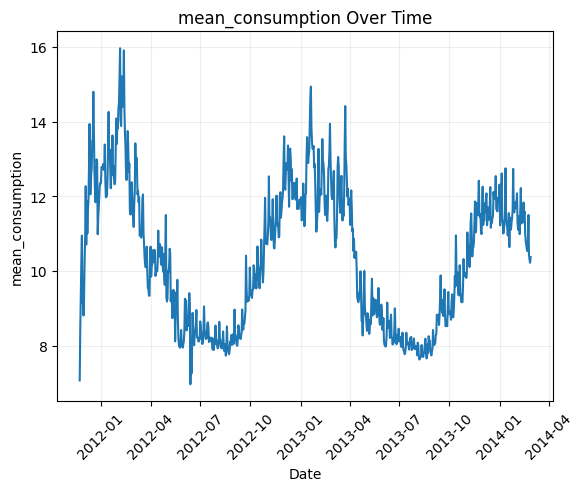

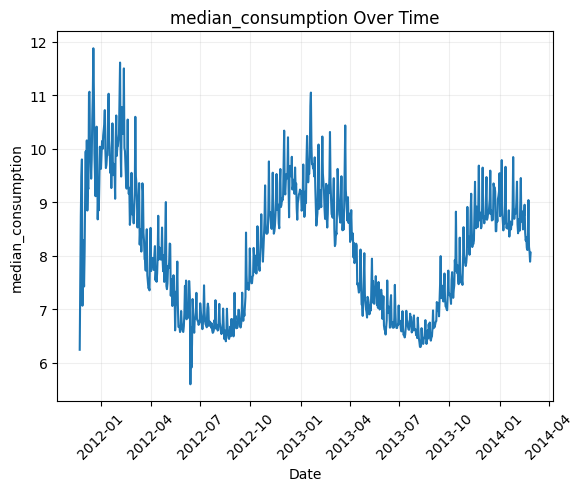

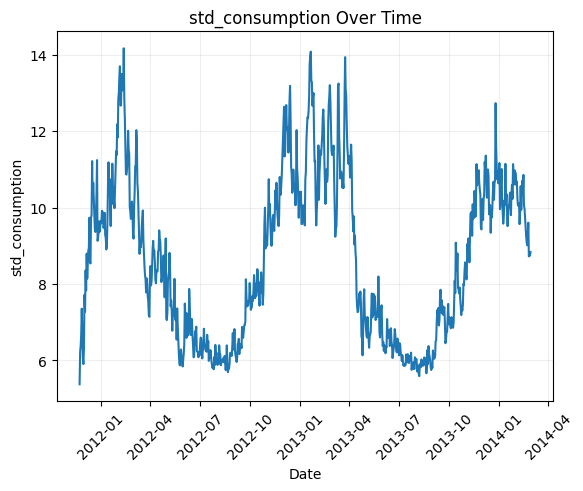

In [40]:
parameters= list(stats_kwh.columns[1:])
for parameter in parameters:
  plt.plot(stats_kwh['date'], stats_kwh[parameter])
  plt.xlabel('Date')
  plt.ylabel(f'{parameter}')
  plt.title(f'{parameter} Over Time')
  plt.grid(alpha = 0.2)
  plt.xticks(rotation=45)
  plt.show();

In [41]:
# Check the dates

start_date = min(stats_kwh['date'])
end_date = max(stats_kwh['date'])
measurment_period = end_date - start_date
print(f"Start date: {start_date}")
print(f"End date: {end_date}")
print(f"Measurement period: {measurment_period}")

Start date: 2011-11-23 00:00:00
End date: 2014-02-27 00:00:00
Measurement period: 827 days 00:00:00


### Check for perfect time series

In [42]:
# Verify it's a perfect time series dataset

def is_perfect_timeseries(df, time_col):
    """
    Check whether a dataset is a perfect time series.
    If not, show the issue and where it occurs.
    """
    duplicates = df[df[time_col].duplicated(keep='first')]  # Keeps the first, shows extra ones

    if not duplicates.empty:
        print("Duplicate timestamps found (extra occurrences shown):")
        print(duplicates[[time_col]])
        return False

    # Sort DataFrame by time column and reset index
    df_sorted = df.sort_values(by=time_col).reset_index(drop=True)

    # Infer frequency ignoring the column name
    inferred_freq = pd.infer_freq(df_sorted[time_col])

    if inferred_freq is None:
        print("Inconsistent time intervals detected.")

        # Compute time differences (ignoring first row)
        df_sorted["time_diff"] = df_sorted[time_col].diff()

        # Identify inconsistent time gaps (ignoring the first row)
        inconsistent_rows = df_sorted.loc[df_sorted["time_diff"] != df_sorted["time_diff"].mode()[0], ["time_diff"]].iloc[1:]

        if not inconsistent_rows.empty:
            print("Time gaps detected at these positions:")
            print(inconsistent_rows)

        return False

    print("Perfect time series detected! ✅")
    return True
is_perfect_timeseries(stats_kwh, "date")

Perfect time series detected! ✅


True

# Integrating day of the week

In [43]:
# The start date of the data is "2011-11-23", which is Wednesday
start_date.day_name()

'Wednesday'

In [44]:
# Get a new catrgorical column in the datset that contains the day of the observed date
# 0 = Monday, 6 = Sunday
stats_kwh["day"]= stats_kwh["date"].dt.weekday
stats_kwh.head()

,date,mean_consumption,median_consumption,std_consumption,day
0,2011-11-23,7.063833,6.2460,5.373299,2
1,2011-11-24,8.426043,7.4890,6.219456,3
2,2011-11-25,9.350267,8.7385,6.377867,4
3,2011-11-26,10.255256,9.4770,6.689567,5
4,2011-11-27,10.946154,9.8030,7.351755,6


### Visualizing energy consumption by day

In [45]:
avg_day = stats_kwh.groupby('day')['mean_consumption'].mean()
avg_day

day
0    10.332493
1    10.205572
2    10.147844
3    10.130865
4    10.193475
5    10.466811
6    10.976369
Name: mean_consumption, dtype: float64

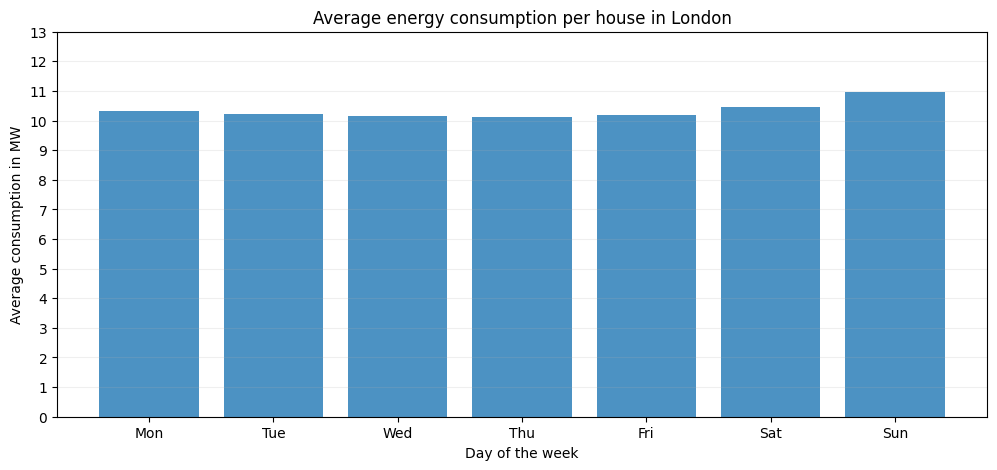

In [46]:
figure = plt.figure(figsize = (12,5))
plt.bar(avg_day.index, avg_day.values, alpha=0.8)
plt.xticks(avg_day.index, ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.yticks(np.arange(0, 14, step = 1))
plt.grid(axis = "y", alpha = 0.2)
plt.xlabel("Day of the week")
plt.ylabel("Average consumption in MW")
plt.title("Average energy consumption per house in London")
plt.show();

In [47]:
# Looks like there is slight more energy consumption during weekends

In [48]:
copy_df = stats_kwh.copy()

# Use vectorized operations to assign values to the 'day' column
copy_df["day"] = copy_df["day"].apply(lambda x: "Weekday" if x < 5 else "Weekend")

copy_df.head()

,date,mean_consumption,median_consumption,std_consumption,day
0,2011-11-23,7.063833,6.2460,5.373299,Weekday
1,2011-11-24,8.426043,7.4890,6.219456,Weekday
2,2011-11-25,9.350267,8.7385,6.377867,Weekday
3,2011-11-26,10.255256,9.4770,6.689567,Weekend
4,2011-11-27,10.946154,9.8030,7.351755,Weekend


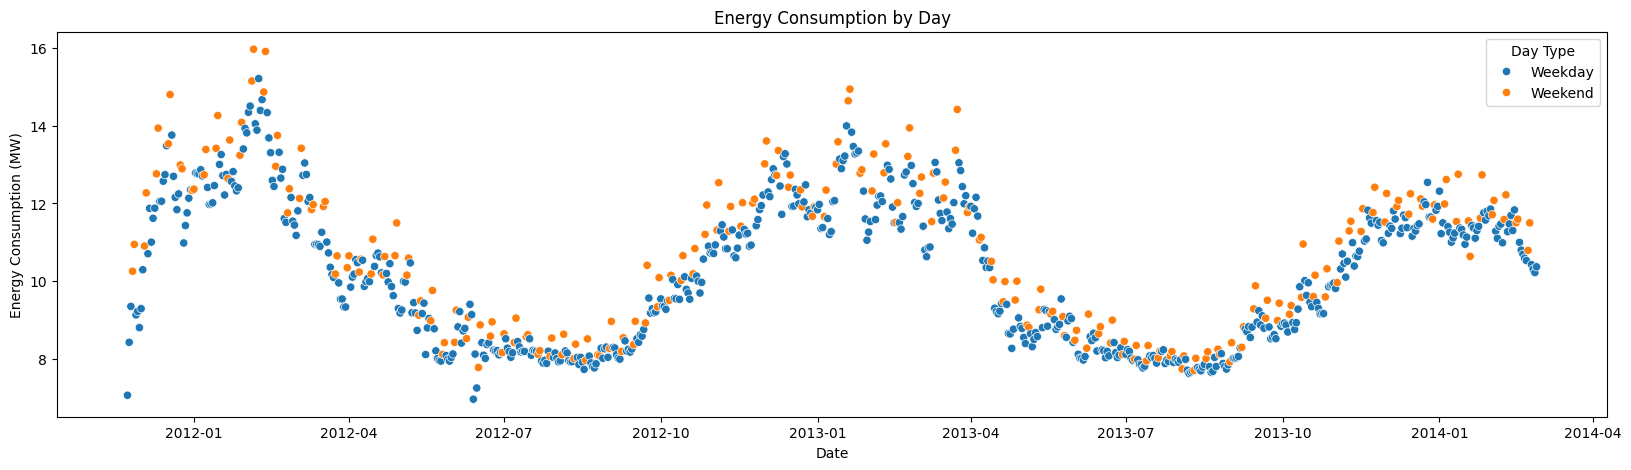

In [49]:
import seaborn as sns
figure = plt.figure(figsize = (20,5))
sns.scatterplot(data = copy_df, x = "date", y = "mean_consumption", hue = "day")
plt.xlabel("Date")
plt.ylabel("Energy Consumption (MW)")
plt.title("Energy Consumption by Day")
plt.legend(title="Day Type")
plt.show();

In [50]:
weekdays = []
weekends = []
for i,  energy in enumerate(avg_day):
  if i < 5:
    weekdays.append(energy)
  else:
    weekends.append(energy)

In [51]:
weekdays_average = sum(weekdays)/len(weekdays)
weekends_average = sum(weekends)/len(weekends)
print(f"Average energy consumption on weekdays: {weekdays_average}")
print(f"Average energy consumption on weekends: {weekends_average}")

Average energy consumption on weekdays: 10.202049820798802
Average energy consumption on weekends: 10.72159032853034


In [52]:
# Increment in energy consumption
increment = ((weekends_average-weekdays_average)/weekdays_average)*100
print(f"The increment in energy consumption on weekdays is by {round(increment, 2)}%")

The increment in energy consumption on weekdays is by 5.09%


# Integrating Bank Holiday

In [53]:
bank_holidays = pd.read_excel("../data/public holiday/ukbankholidays-jul19.xls")

In [54]:
bank_holidays.head()

,UK BANK HOLIDAYS
0,NaT
1,1998-01-01
2,1998-04-10
3,1998-04-13
4,1998-05-04


In [55]:
bank_holidays["UK BANK HOLIDAYS"] = pd.to_datetime(bank_holidays["UK BANK HOLIDAYS"], format = "%Y/%m/%d")

In [56]:
holiday_list = []
start_date=min(df['Date'])
end_date= max(df["Date"])
for i, holiday in enumerate(bank_holidays["UK BANK HOLIDAYS"]):
  if holiday>= start_date and holiday <= end_date:
    holiday_list.append(holiday)

In [57]:
len(holiday_list)

20

In [58]:
stats_kwh['holiday'] = stats_kwh['date'].dt.date.isin([holiday.date() for holiday in holiday_list]).astype(int)
stats_kwh.head()

,date,mean_consumption,median_consumption,std_consumption,day,holiday
0,2011-11-23,7.063833,6.2460,5.373299,2,0
1,2011-11-24,8.426043,7.4890,6.219456,3,0
2,2011-11-25,9.350267,8.7385,6.377867,4,0
3,2011-11-26,10.255256,9.4770,6.689567,5,0
4,2011-11-27,10.946154,9.8030,7.351755,6,0


In [59]:
stats_kwh["holiday"].value_counts()

holiday
0    808
1     20
Name: count, dtype: int64

In [60]:
avg_holiday = stats_kwh.groupby("holiday")["mean_consumption"].mean()

In [61]:
avg_holiday

holiday
0    10.340165
1    10.746519
Name: mean_consumption, dtype: float64

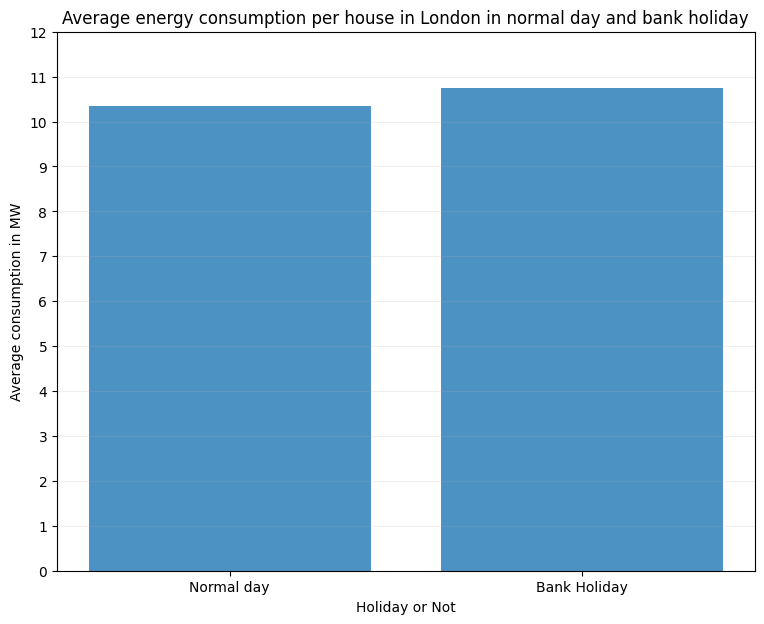

In [62]:
figure = plt.figure(figsize = (9,7))
plt.bar(avg_holiday.index, avg_holiday.values, alpha = 0.8)
plt.xticks(avg_holiday.index, ["Normal day", "Bank Holiday"])
plt.yticks(np.arange(0, max(avg_holiday.values)+2))
plt.grid(axis = "y", alpha = 0.2)
plt.xlabel("Holiday or Not")
plt.ylabel("Average consumption in MW")
plt.title("Average energy consumption per house in London in normal day and bank holiday")
plt.show();

In [63]:
normal_day = []
holiday = []
for i,  energy in enumerate(avg_holiday):
  if i == 0:
    normal_day.append(energy)
  else:
    holiday.append(energy)

In [64]:
normal_average = sum(normal_day)/len(normal_day)
holiday_average = sum(holiday)/len(holiday)
print(f"Average energy consumption on normal days: {normal_average}")
print(f"Average energy consumption on bank holidays: {holiday_average}")

Average energy consumption on normal days: 10.340164644733719
Average energy consumption on bank holidays: 10.746519410097807


In [65]:
holiday_increment = ((holiday_average-normal_average)/normal_average)*100
print(f"The increment in energy consumption on bank holidays is by {round(holiday_increment, 2)}%")

The increment in energy consumption on bank holidays is by 3.93%


In [66]:
# Just like the weekends, there is more energy consumption on bank  than on normal days

In [68]:
stats_kwh.to_csv("../data/processed data/processed_energy_data.csv", index=False)

# Exploring further

In [80]:
stats_kwh.head()

,date,mean_consumption,median_consumption,std_consumption,day,holiday
0,2011-11-23,7.063833,6.2460,5.373299,2,0
1,2011-11-24,8.426043,7.4890,6.219456,3,0
2,2011-11-25,9.350267,8.7385,6.377867,4,0
3,2011-11-26,10.255256,9.4770,6.689567,5,0
4,2011-11-27,10.946154,9.8030,7.351755,6,0


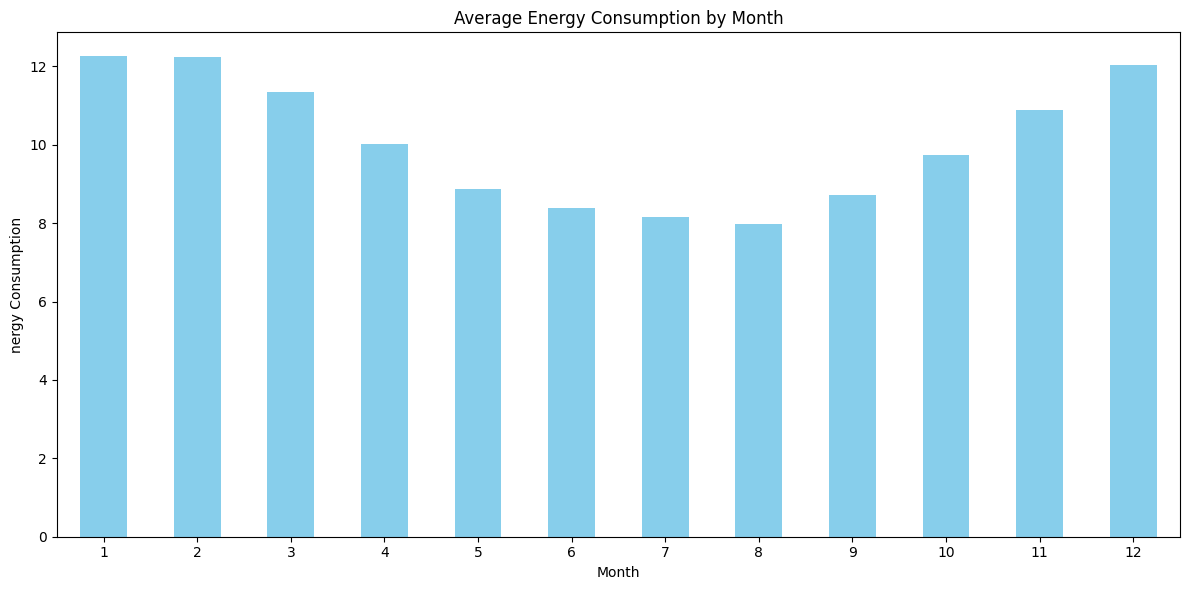

In [81]:
# Group by month and calculate average energy consumption
analysis_df = stats_kwh.copy()
analysis_df['month'] = analysis_df['date'].dt.month

monthly_energy = analysis_df.groupby('month')['mean_consumption'].mean()
plt.figure(figsize=(12,6))
monthly_energy.plot(kind='bar', color='skyblue')

# Add titles and labels
plt.title('Average Energy Consumption by Month')
plt.xlabel('Month')
plt.ylabel('nergy Consumption')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# By the chart, people tend to consume more energy on winter months (November-march) and less on summer months (april-october).
# This shows the potential of correlation of weather parameters (especially temperature) with energy consumption

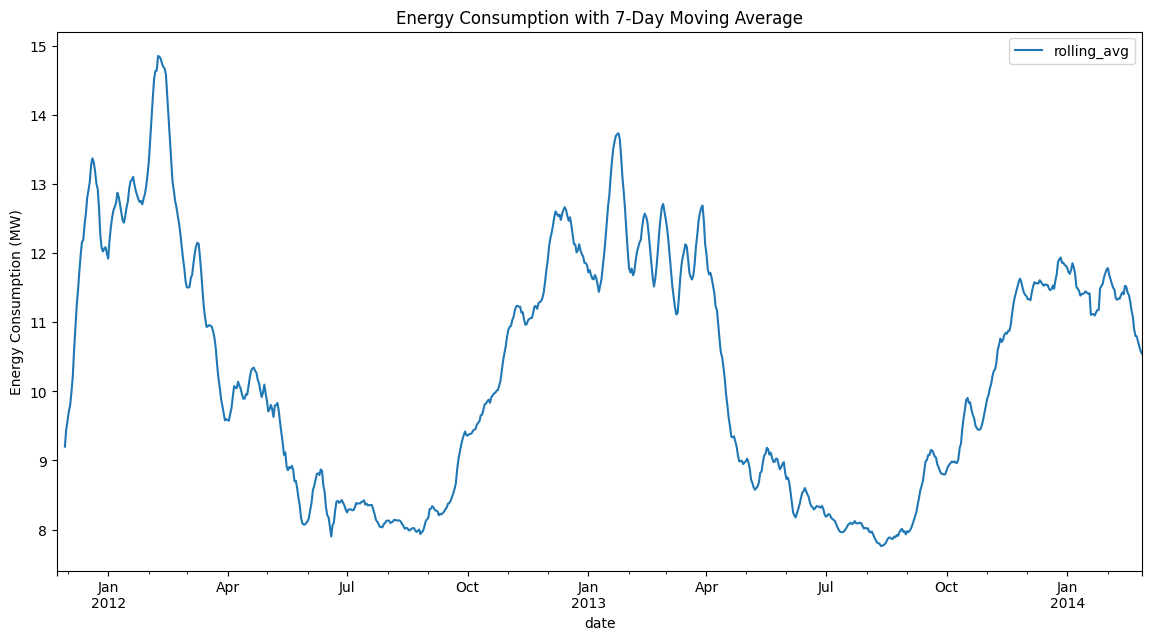

In [85]:
copy_df['rolling_avg'] = copy_df['mean_consumption'].rolling(window=7).mean()
copy_df.plot(x='date', y="rolling_avg", figsize=(14, 7), title='Energy Consumption with 7-Day Moving Average')
plt.ylabel('Energy Consumption (MW)')
plt.show();

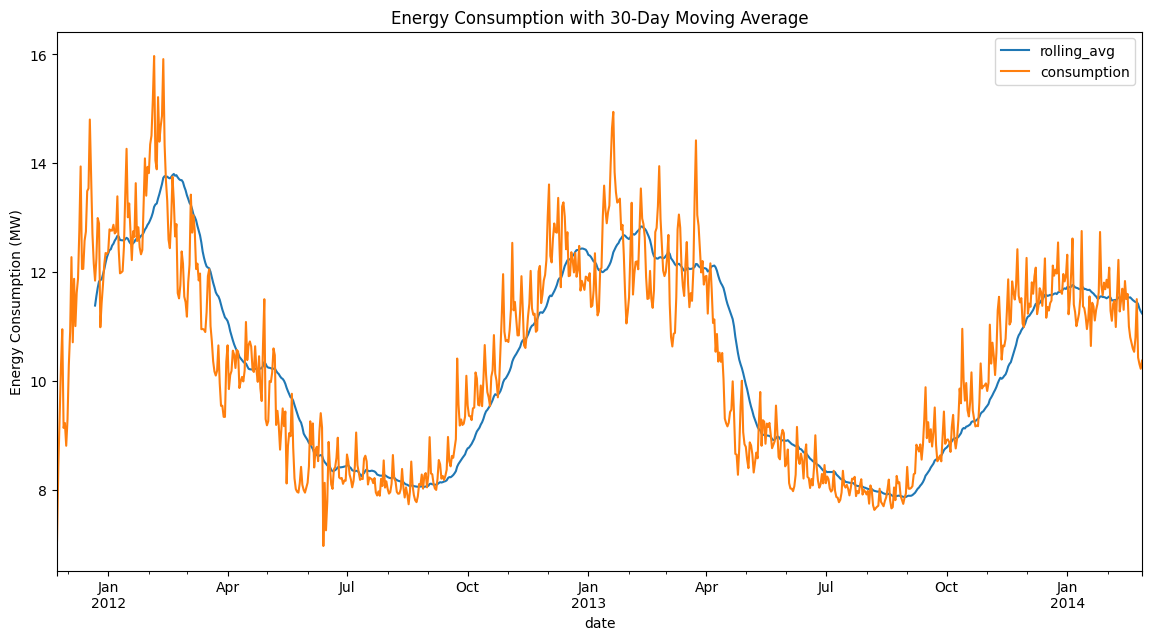

In [ ]:
copy_df['rolling_avg'] = copy_df['consumption'].rolling(window=30).mean()
copy_df.plot(x='date', y=["rolling_avg", "consumption"], figsize=(14, 7), title='Energy Consumption with 30-Day Moving Average')
plt.ylabel('Energy Consumption (MW)')
plt.show();

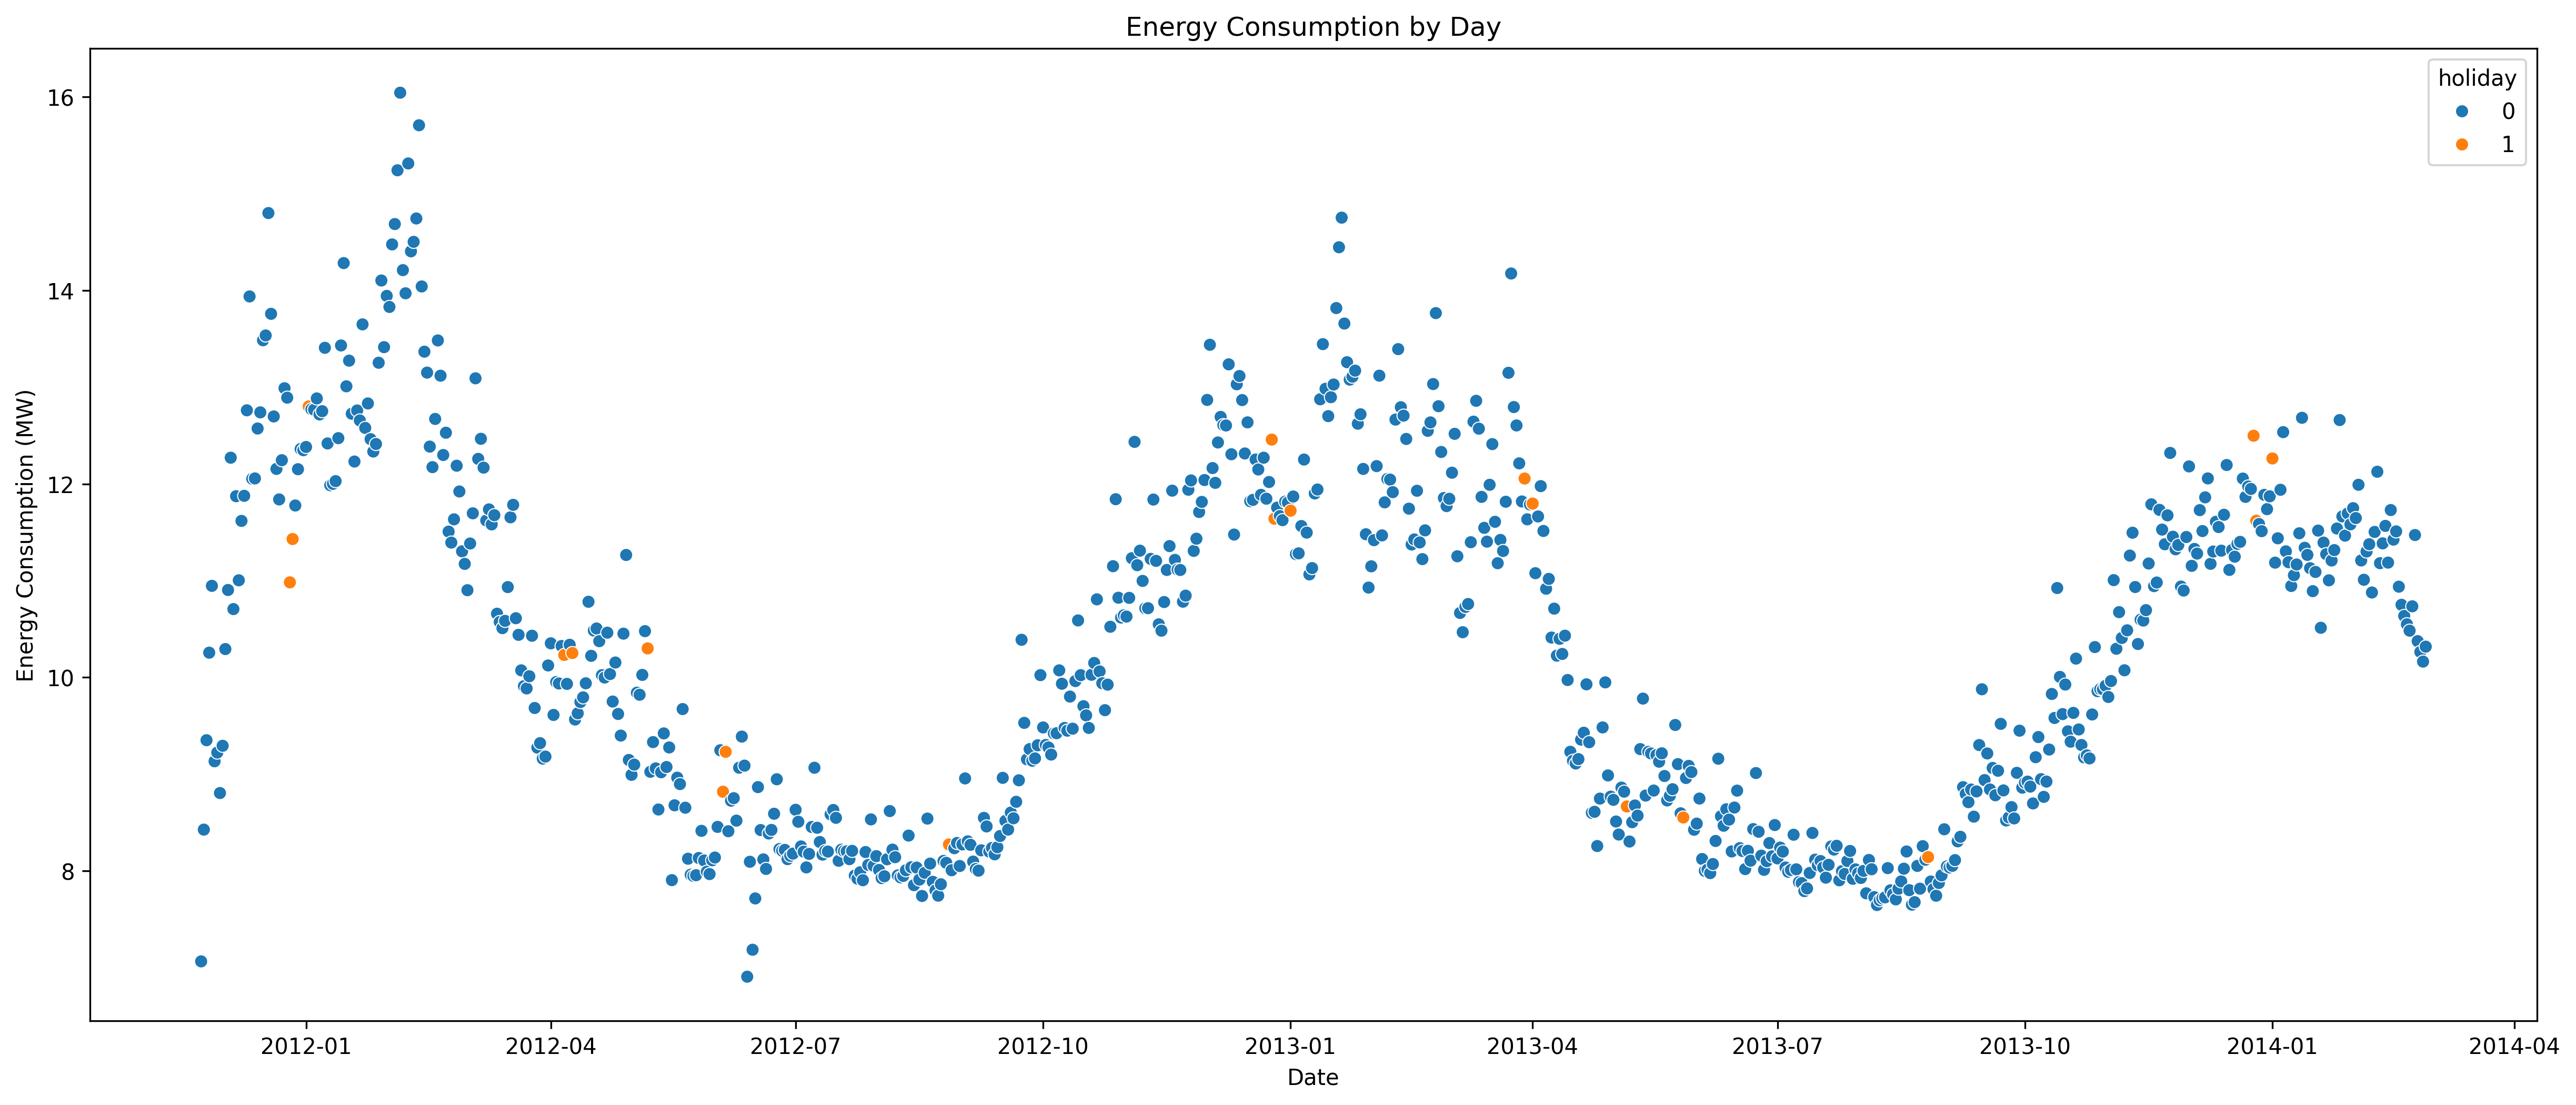

In [151]:
plt.figure(figsize = (20,8), dpi = 300)
sns.scatterplot(data = analysis_df, x = "date", y = "mean_consumption", hue = "holiday")
plt.xlabel("Date")
plt.ylabel("Energy Consumption (MW)")
plt.title("Energy Consumption by Day")
plt.show();

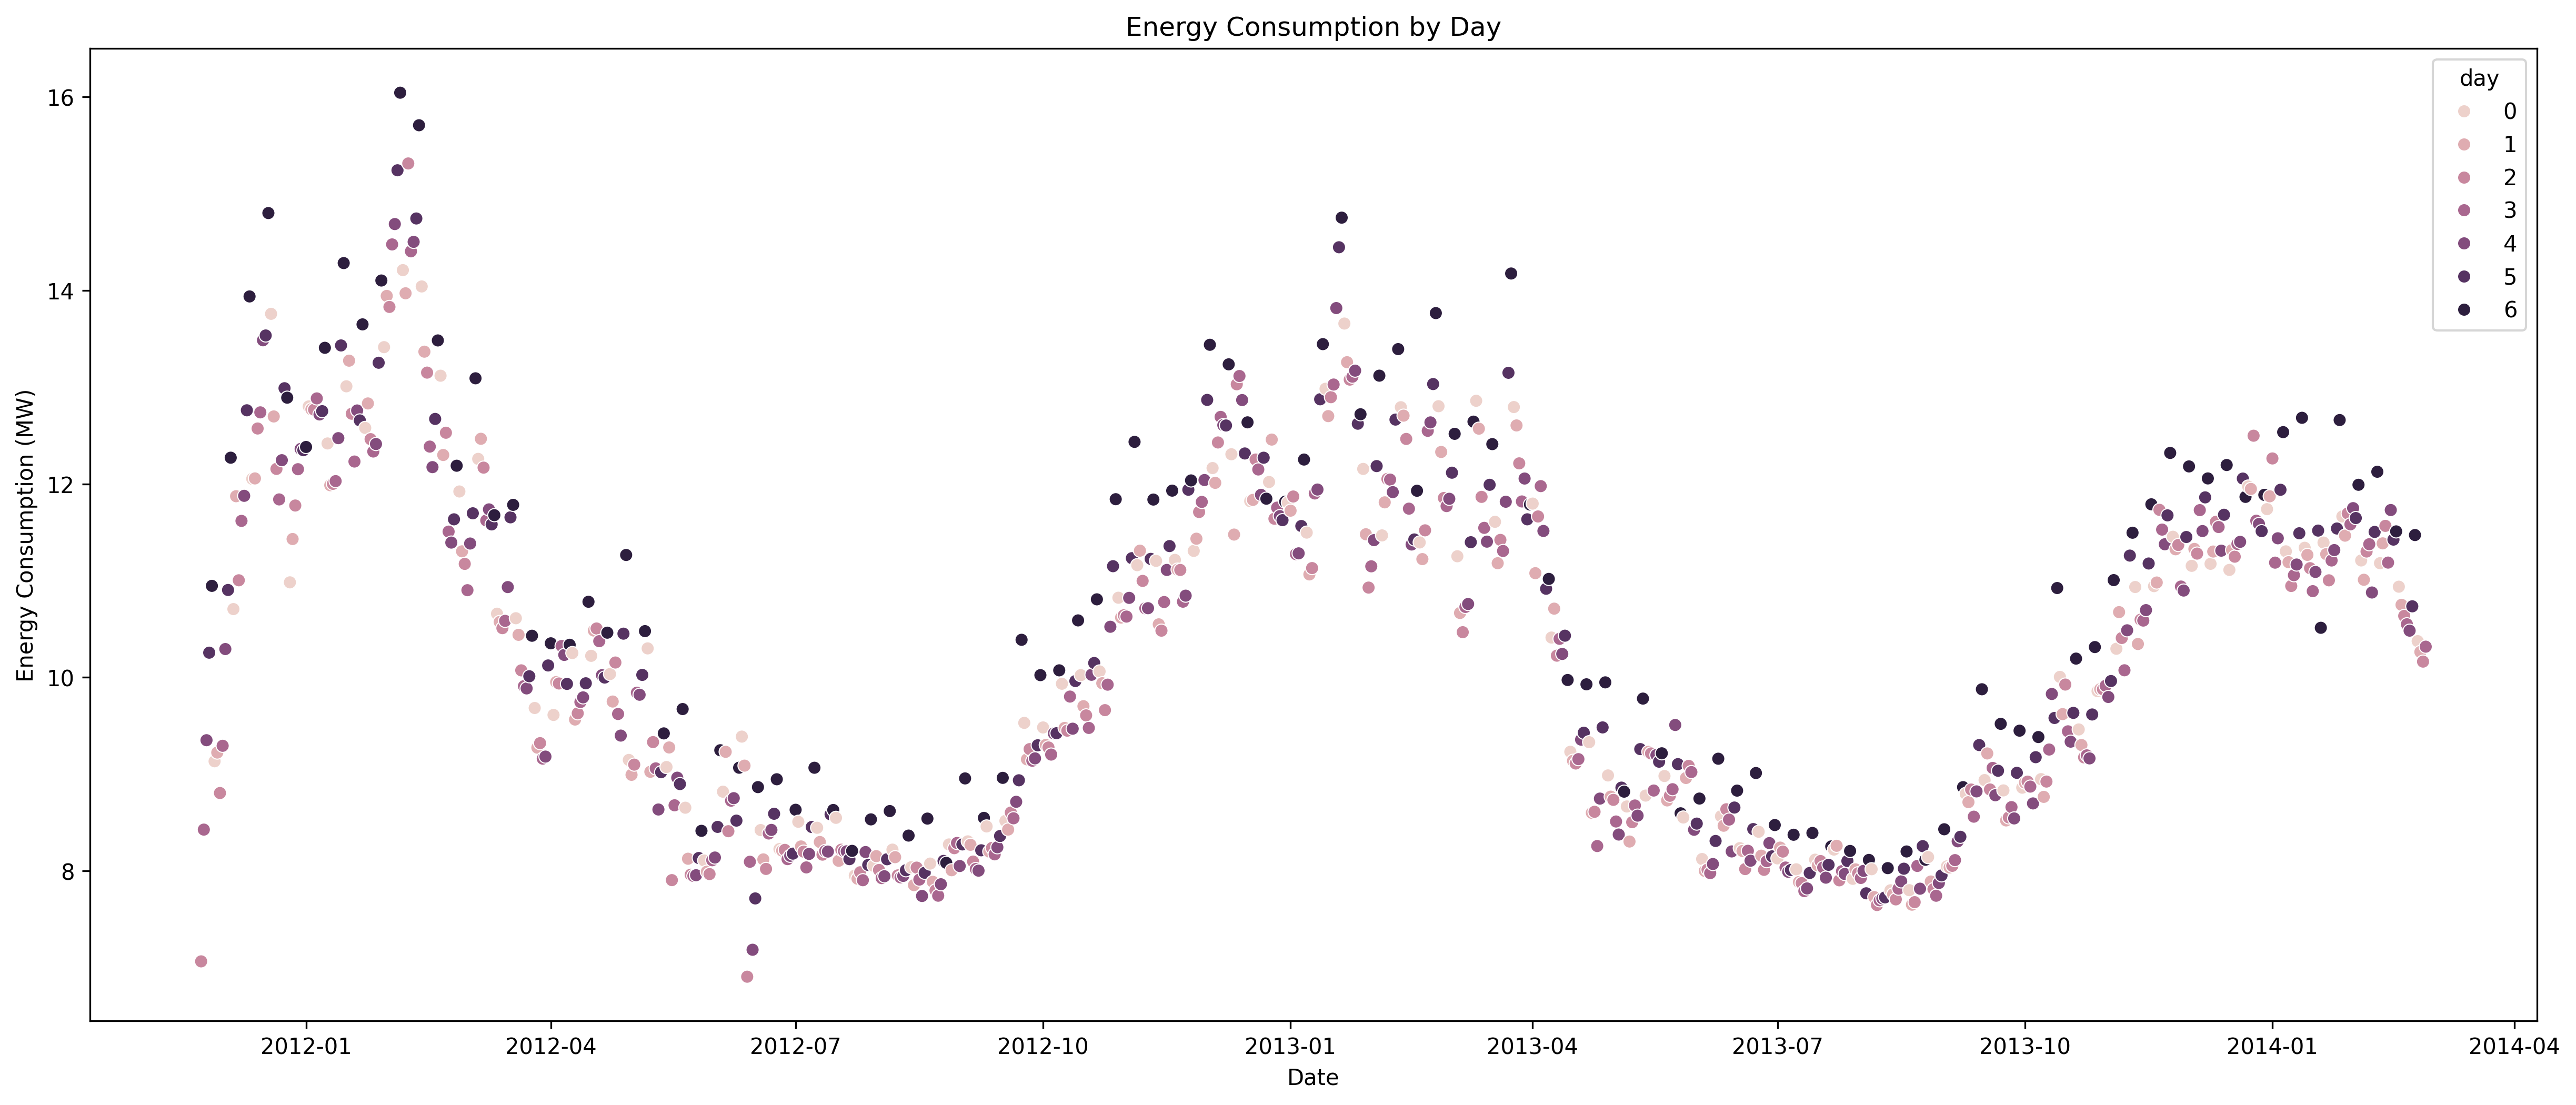

In [152]:

plt.figure(figsize = (20,8), dpi = 300)
sns.scatterplot(data = analysis_df, x = "date", y = "mean_consumption", hue = "day")
plt.xlabel("Date")
plt.ylabel("Energy Consumption (MW)")
plt.title("Energy Consumption by Day")
plt.show();